In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, 

import os
print(os.listdir("chest_xray"))
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k

['train', '.DS_Store', 'test', 'val']


In [18]:
imagePatches = glob('chest_xray/**/**/*.jpeg', recursive=True)
print(len(imagePatches))

17568


In [0]:
pattern_normal = '*NORMAL*'
pattern_bacteria = '*_bacteria_*'
pattern_virus = '*_virus_*'

normal = fnmatch.filter(imagePatches, pattern_normal)
bacteria = fnmatch.filter(imagePatches, pattern_bacteria)
virus = fnmatch.filter(imagePatches, pattern_virus)
x = []
y = []
for img in imagePatches:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    if img in normal:
        y.append(0)
    elif img in bacteria:
        y.append(1)
    elif img in virus:
        y.append(1)
    else:
        #break
        print('no class')
x = np.array(x)
y = np.array(y)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)
del x, y

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 
model = Sequential()
model.add(Conv2D(32,(7,7),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(GlobalAveragePooling2D())
model.add(Dense(1000, activation='relu'))
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
#model.summary()


In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='best_architecture.png', show_shapes=True, show_layer_names=True)

In [0]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='model_check.h5',monitor="val_acc", save_best_only=True, save_weights_only=False)

In [29]:

hist = model.fit(x_train,y_train,batch_size = 32, epochs = 40, verbose=1,  validation_split=0.2, callbacks=[mcp])
model.save_weights('new.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 11243 samples, validate on 2811 samples
Epoch 1/40
11243/11243 [==============================] - 71s 6ms/step - loss: 0.2557 - acc: 0.8962 - val_loss: 0.5397 - val_acc: 0.7981
Epoch 2/40
11243/11243 [==============================] - 66s 6ms/step - loss: 0.1842 - acc: 0.9285 - val_loss: 2.1521 - val_acc: 0.3340
Epoch 3/40
11243/11243 [==============================] - 66s 6ms/step - loss: 0.1550 - acc: 0.9430 - val_loss: 0.3520 - val_acc: 0.8534
Epoch 4/40
11243/11243 [==============================] - 66s 6ms/step - loss: 0.1348 - acc: 0.9501 - val_loss: 0.3298 - val_acc: 0.8485
Epoch 5/40
11243/11243 [==============================] - 66s 6ms/step - loss: 0.1211 - acc: 0.9545 - val_loss: 0.2312 - val_acc: 0.8972
Epoch 6/40
11243/11243 [==============================] - 65s 6ms/step - loss: 0.1061 - acc: 0.9610 - v

In [0]:
from keras.models import load_model
model.save('model.h5')

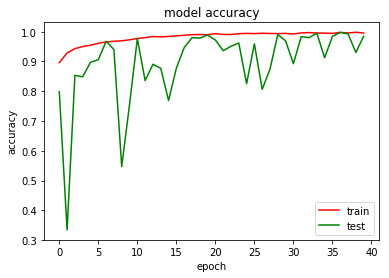

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['acc'], color='red')
ax.plot(hist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

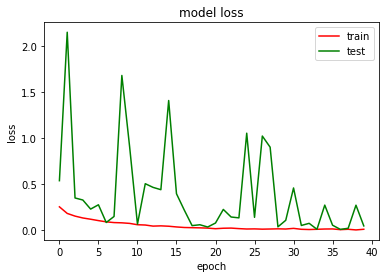

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['loss'], color='red')
ax.plot(hist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       959
           1       0.98      1.00      0.99      2555

   micro avg       0.98      0.98      0.98      3514
   macro avg       0.99      0.97      0.98      3514
weighted avg       0.98      0.98      0.98      3514



In [0]:
model.load_weights('model_check.h5')

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

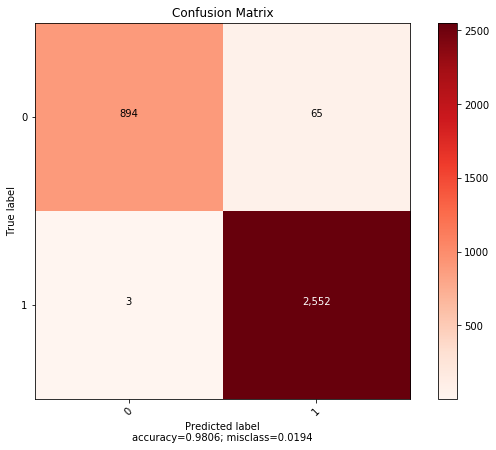

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")

In [0]:
#testing results on one image
image = cv2.imread('chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg')
re_im = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
re_im =np.expand_dims(re_im,axis=0)

In [0]:
result = model.predict(re_im)

In [39]:
result

array([[0.95959294, 0.04274617]], dtype=float32)